In [1]:
import time 
from qutip import mesolve, steadystate
import numpy as np
import optical as EM
import phonons as RC
import leads as FL
from utils import *
from style import *
from photocell_setup import *
#from importlib import reload

utils imported


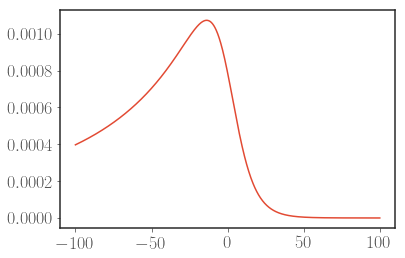

In [2]:
w = np.linspace(-100, 100, 1000)
plt.plot(w, FL.J_Lorentzian(w, 10, 100, Gamma=1)*FL.fermi_occ(w, 10, 0.) )
#plt.plot(w, FL.J_Lorentzian(w, 10,100,Gamma=1)*(1-FL.fermi_occ(w, 10, 0.)))
#plt.plot(w, J_underdamped(w, 10,10,alpha=1/(2*pi)) )
plt.show()

In [3]:
reload(RC)
reload(EM)
reload(FL)

def dynamics( H, L, PARAMS, tf=10, tN=1000):
    timelist = np.linspace(0, tf, tN)
    ops = make_expectation_operators(PARAMS)
    rho_0 = tensor(0.5*(exciton_ket+vac_ket)*(exciton_ket.dag()+vac_ket.dag()), 
                   thermal_dm(PARAMS['N'], Occupation(PARAMS['Omega_RC'], PARAMS['T_ph'])))
    data = mesolve(H, rho_0, timelist, c_ops=[L], e_ops=[ops['exciton'], ops['real_coherence'], 
                                                         ops['imag_coherence']], 
                   options=qt.Options(nsteps=15000))
    plt.figure()
    plt.plot(timelist, data.expect[0])
    plt.figure()
    plt.plot(timelist, data.expect[1])
    plt.show()

def build_full_L(PARAMS, silent=True):
    # RC mapping on operators etc
    PARAMS, L_RC, H_S, A_nrwa, A_RC, A_L, A_R = RC.RC_mapping(PARAMS, silent=silent)
    H = H_S # H_S
    H_add = tensor(PARAMS['H_sub'], qeye(PARAMS['N']))
    # optical liouv and additive
    if PARAMS['radiative_lifetime'] == np.infty:
        L_EM_add = L_EM = 0
    else:
        L_EM = EM.L_non_rwa(H_S, A_nrwa, PARAMS['omega_exciton'], PARAMS['Gamma_EM'], 
                            PARAMS['T_EM'], PARAMS['J'],
                                    silent=silent, tol=0)
    
    #  Left and right leads and additive
    #L_L, L_R = FL.L_R_lead_dissipators(H_S, PARAMS, real_only=False, silent=False)
    L_L, L_R = FL.L_R_lead_dissipators(H, PARAMS, silent=silent)
    # dict of various combinations    
    L_dict = {'PARAMS': PARAMS, 'H_S': H_S, 'L_EM': L_EM, 'L_R': L_R, 
                                            'L_full' : L_EM+L_L+L_R+L_RC}
    return L_dict # dict

def build_Lindblad_L(PARAMS, silent=True):
    # RC mapping on operators etc
    PARAMS, L_RC, H_S, A_nrwa, A_RC, A_L, A_R = RC.RC_mapping(PARAMS, silent=silent)
    H = H_S # H_S
    H_add = tensor(PARAMS['H_sub'], qeye(PARAMS['N']))
    # optical liouv and additive
    if PARAMS['radiative_lifetime'] == np.infty:
        L_EM_add = L_EM = 0
    else:
        L_EM = EM.L_non_rwa(H_S, A_nrwa, PARAMS['omega_exciton'], PARAMS['Gamma_EM'], 
                            PARAMS['T_EM'], PARAMS['J'],
                                    silent=silent, tol=0)
    
    #  Left and right leads and additive
    #L_L, L_R = FL.L_R_lead_dissipators(H_S, PARAMS, real_only=False, silent=False)
    L_L_lindblad, L_R_lindblad = L_left_and_right_secular(H, PARAMS)
    # dict of various combinations    
    L_dict = {'PARAMS': PARAMS, 'H_S': H_S, 'L_EM': L_EM, 'L_R_lindblad': L_R_lindblad, 
                                            'L_lindblad' : L_EM+L_L_lindblad+L_R_lindblad+L_RC}
    return L_dict # dict

def build_all_L(PARAMS, silent=True):
    # RC mapping on operators etc
    PARAMS, L_RC, H_S, A_nrwa, A_RC, A_L, A_R = RC.RC_mapping(PARAMS, silent=silent)
    H = H_S # H_S
    H_add = tensor(PARAMS['H_sub'], qeye(PARAMS['N']))
    # optical liouv and additive
    if PARAMS['radiative_lifetime'] == np.infty:
        L_EM_add = L_EM = 0
    else:
        L_EM = EM.L_non_rwa(H_S, A_nrwa, PARAMS['omega_exciton'], PARAMS['Gamma_EM'], 
                            PARAMS['T_EM'], PARAMS['J'],
                                    silent=silent, tol=0)
        L_EM_add = EM.L_non_rwa(H_add, A_nrwa, PARAMS['omega_exciton'], PARAMS['Gamma_EM'], 
                                PARAMS['T_EM'], PARAMS['J'],
                                    silent=silent, tol=0)
    
    #  Left and right leads and additive
    L_L, L_R = FL.L_R_lead_dissipators(H, PARAMS, silent=silent)
    L_L_lindblad, L_R_lindblad = L_left_and_right_secular(H, PARAMS)
    L_L_add, L_R_add = FL.L_left_nonadditive(H_add, PARAMS), FL.L_right_nonadditive(H_add, PARAMS)
    # dict of various combinations    
    L_dict = {'PARAMS': PARAMS, 'H_S': H_S, 'L_EM': L_EM, 'L_R': L_R, 'L_R_lindblad': L_R_lindblad,
                                            'L_full' : L_EM+L_L+L_R+L_RC,
                                            'L_lindblad' : L_EM+L_L_lindblad+L_R_lindblad+L_RC,
                                            'L_add_EM' : L_EM_add+L_R+L_L+L_RC,
                                            'L_add_leads' : L_EM+L_L_add+L_R_add+L_RC,
                                            'L_no_EM' : L_R+L_L+L_RC}
    return L_dict # dict
#return H_S, L_RC, L_EM, L_EM_add, L_L, L_R, L_L_add, L_R_add



In [4]:
def secular_term(state_j, state_k):
    jk = state_j*state_k.dag()
    kj = jk.dag()
    jj = state_j*state_j.dag()
    return sprepost(kj, jk) - 0.5*(spre(jj) + spost(jj))

def L_left_and_right_secular(H, PARAMS):
    ti = time.time()
    energies, states = H.eigenstates()
    A_R = tensor(PARAMS['A_R'], qeye(PARAMS['N']))
    A_L = tensor(PARAMS['A_L'], qeye(PARAMS['N']))
    H_dim = len(energies)
    Lambda_up_R = lambda x :  FL.Lamdba_complex_rate(x, FL.J_Lorentzian, PARAMS['mu_R'], PARAMS['T_R'], PARAMS['Gamma_R'], 
                                                    PARAMS['delta_R'], PARAMS['Omega_R'], type='p', real_only=True)
    Lambda_down_R = lambda x :  FL.Lamdba_complex_rate(x, FL.J_Lorentzian, PARAMS['mu_R'], PARAMS['T_R'], PARAMS['Gamma_R'], 
                                                    PARAMS['delta_R'], PARAMS['Omega_R'], type='m', real_only=True)
    
    Lambda_up_L = lambda x :  FL.Lamdba_complex_rate(x, FL.J_Lorentzian, PARAMS['mu_L'], PARAMS['T_L'], PARAMS['Gamma_L'], 
                                                    PARAMS['delta_L'], PARAMS['Omega_L'], type='p', real_only=True)
    Lambda_down_L = lambda x :  FL.Lamdba_complex_rate(x, FL.J_Lorentzian, PARAMS['mu_L'], PARAMS['T_L'], PARAMS['Gamma_L'], 
                                                    PARAMS['delta_L'], PARAMS['Omega_L'], type='m', real_only=True)
    
    L_L = L_R = 0
    for j in range(H_dim):
        for k in range(H_dim):
            omega_jk = energies[j]-energies[k]
            state_j, state_k = states[j], states[k]
            
            A_dag_jk = A_R.dag().matrix_element(state_j, state_k)
            A_kj = A_R.matrix_element(state_k, state_j)
            coeff = A_dag_jk*A_kj
            if np.abs(coeff) > 0:
                L_R += Lambda_down_R(omega_jk)*coeff*secular_term(state_j, state_k)
                L_R += Lambda_up_R(omega_jk)*coeff*secular_term(state_k, state_j)
            
            A_dag_jk = A_L.dag().matrix_element(state_j, state_k)
            A_kj = A_L.matrix_element(state_k, state_j)
            coeff = A_dag_jk*A_kj
            if np.abs(coeff) > 0:
                L_L += Lambda_up_L(-omega_jk)*coeff*secular_term(state_j, state_k)
                L_L += Lambda_down_L(-omega_jk)*coeff*secular_term(state_k, state_j)
    #print(time.time() - ti)
    return L_L, L_R

In [5]:
def L_left_and_right_electronic(PARAMS):
    ti = time.time()
    energies, states = PARAMS['H_sub'].eigenstates()
    A_R = d_e
    A_L = d_h
    H_dim = len(energies)
    Lambda_up_R = lambda x :  FL.Lamdba_complex_rate(x, FL.J_Lorentzian, PARAMS['mu_R'], PARAMS['T_R'], PARAMS['Gamma_R'], 
                                                    PARAMS['delta_R'], PARAMS['Omega_R'], type='p', real_only=True)
    Lambda_down_R = lambda x :  FL.Lamdba_complex_rate(x, FL.J_Lorentzian, PARAMS['mu_R'], PARAMS['T_R'], PARAMS['Gamma_R'], 
                                                    PARAMS['delta_R'], PARAMS['Omega_R'], type='m', real_only=True)
    
    Lambda_up_L = lambda x :  FL.Lamdba_complex_rate(x, FL.J_Lorentzian, PARAMS['mu_L'], PARAMS['T_L'], PARAMS['Gamma_L'], 
                                                    PARAMS['delta_L'], PARAMS['Omega_L'], type='p', real_only=True)
    Lambda_down_L = lambda x :  FL.Lamdba_complex_rate(x, FL.J_Lorentzian, PARAMS['mu_L'], PARAMS['T_L'], PARAMS['Gamma_L'], 
                                                    PARAMS['delta_L'], PARAMS['Omega_L'], type='m', real_only=True)
    
    L_L = L_R = 0
    for j in range(H_dim):
        for k in range(H_dim):
            omega_jk = energies[j]-energies[k]
            state_j, state_k = states[j], states[k]
            
            A_dag_jk = A_R.dag().matrix_element(state_j, state_k)
            A_kj = A_R.matrix_element(state_k, state_j)
            coeff = A_dag_jk*A_kj
            if np.abs(coeff) > 0:
                L_R += Lambda_down_R(omega_jk)*coeff*secular_term(state_j, state_k)
                L_R += Lambda_up_R(omega_jk)*coeff*secular_term(state_k, state_j)
            
            A_dag_jk = A_L.dag().matrix_element(state_j, state_k)
            A_kj = A_L.matrix_element(state_k, state_j)
            coeff = A_dag_jk*A_kj
            if np.abs(coeff) > 0:
                L_L += Lambda_up_L(-omega_jk)*coeff*secular_term(state_j, state_k)
                L_L += Lambda_down_L(-omega_jk)*coeff*secular_term(state_k, state_j)
    #print(time.time() - ti)
    return L_L, L_R

In [6]:
def current_from_L(L_dict, n_c_RC):
    ss = steadystate(L_dict['H_S'], [L_dict['L_lindblad']])
    return -(qt.vector_to_operator(L_dict['L_R']*qt.operator_to_vector(ss))*n_c_RC).tr()

def current_from_ss(ss, L_R, n_c_RC):
    return -(qt.vector_to_operator(L_R*qt.operator_to_vector(ss))*n_c_RC).tr()

def current_and_obs_from_L(H, L_full, L_track, obs_ops):
    obs_out = []
    rho_ss = qt.steadystate(H, [L_full])
    obs_out.append(-(qt.vector_to_operator(L_track*qt.operator_to_vector(rho_ss))*obs_ops[0]).tr())
    for obs in obs_ops[1::]:
        obs_out.append((rho_ss*obs).tr())
    del rho_ss
    return obs_out

def band_populations_voltage(PARAMS):
    #bias_voltages = [0, 0.5, 1]
    bias_voltages = np. linspace(0, PARAMS['omega_exciton']*1., 100)
    conduction_population = []
    valence_population = []
    for i, bv in enumerate(bias_voltages):
        PARAMS.update({'mu_R': PARAMS['mu_L']+bv})
        #if i in [10, 90]:
        #    print_PARAMS(PARAMS)
        L_Lindblad_dict = build_Lindblad_L(PARAMS, silent=True)
        #ops = make_expectation_operators(PARAMS)
        n_c = tensor(d_e.dag()*d_e, qeye(PARAMS['N']))
        n_v = tensor(d_h.dag()*d_h, qeye(PARAMS['N']))
        ss = steadystate(L_Lindblad_dict['H_S'], [L_Lindblad_dict['L_lindblad']])
        if i in [10, 90]:
            print( ss.ptrace(0) )
        conduction_population.append((n_c*ss).tr())
        valence_population.append((n_v*ss).tr())
    bias_voltages/=ev_to_inv_cm
    return bias_voltages, conduction_population, valence_population

def simple_current_voltage(PARAMS, x_scale=1):
    bias_voltages = np. linspace(0, PARAMS['omega_exciton']*x_scale, 100)
    currents = []
    for i, bv in enumerate(bias_voltages):
        PARAMS.update({'mu_R': PARAMS['mu']+bv/2, 'mu_L': PARAMS['mu']-bv/2})
        #if i in [10, 90]:
        #    print_PARAMS(PARAMS)
        L_Lindblad_dict = build_Lindblad_L(PARAMS, silent=True)
        #ops = make_expectation_operators(PARAMS)
        n_c = tensor(d_e.dag()*d_e, qeye(PARAMS['N']))
        ss = steadystate(L_Lindblad_dict['H_S'], [L_Lindblad_dict['L_lindblad']])
        currents.append(current_from_ss(ss, L_Lindblad_dict['L_R_lindblad'], n_c))
        
        if i in [10, 90]:
            print( ss.ptrace(0) )
            print_PARAMS(PARAMS)
    bias_voltages/=ev_to_inv_cm
    return bias_voltages, currents


Phonon occupation: 2.12. Phonon thermal energy is 208.50. Phonon SD peak is 0.00. V=0.0. N=3.
Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 0.91033613  0.          0.          0.        ]
 [ 0.          0.02988796  0.          0.        ]
 [ 0.          0.          0.02988796  0.        ]
 [ 0.          0.          0.          0.02988796]]
Omega_RC : 80.655
gamma_RC : 0.0159154943092
bandgap : 11291.7
mu_R : 7755.91515152
mu_L : 5148.88484848
delta_R : 24.1965
energy_shift : 0.0
mu : 6452.4
Omega_ph : 80.655
T_ph : 300.0
binding_energy : 0.0
deformation_ratio : 0.5
radiative_lifetime : 1
leads_lifetime : 1
omega_exciton : 12904.8
Gamma_EM : 0.005309
Omega_R : 12098.25
J : <function J_minimal at 0x7f8e16fb2050>
omega_v : 806.55
T_EM : 5800
alpha_ph : 0.0
Omega_L : -806.55
omega_c : 12098.25
N : 3
Gamma_L : 0.005309
T_L : 300.0
sys_dim : 4
Gamma_ph : 8.0655
delta_L : 24.1965
T_R : 300.0
kappa_RC : 0.0
Gamma_R : 0.005309
Quantum object: dims 

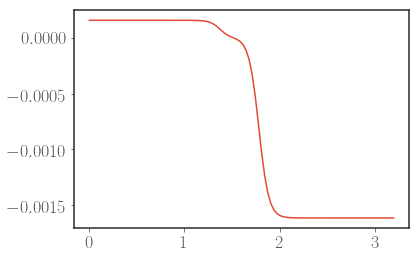

In [7]:
PARAMS = PARAMS_setup(binding_energy=0.0, radiative_lifetime=1, alpha_ph=0, mu=800e-3,
                      bias_voltage=0, N=3, silent=False)
V_values, I = simple_current_voltage(PARAMS, x_scale=2)
plt.plot(V_values, np.array(I).real)
plt.show()

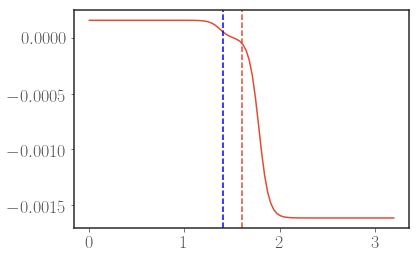

In [13]:
plt.plot(V_values, np.array(I).real)
plt.axvline(PARAMS['omega_exciton']/ev_to_inv_cm, linestyle='dashed')
plt.axvline(PARAMS['bandgap']/ev_to_inv_cm, linestyle='dashed', color='b')
plt.show()

In [8]:
12904.8/ev_to_inv_cm

1.5999999999999999

In [9]:
PARAMS = PARAMS_setup(binding_energy=0, radiative_lifetime=1, alpha_ph=0, mu=800e-3, T_EM=0,
                      bias_voltage=0, N=3, silent=False)
V_values, I = simple_current_voltage(PARAMS, x_scale=2)
plt.plot(V_values, np.array(I).real)
plt.show()

Phonon occupation: 2.12. Phonon thermal energy is 208.50. Phonon SD peak is 0.00. V=0.0. N=3.


KeyboardInterrupt: 

In [ ]:
PARAMS = PARAMS_setup(binding_energy=0, radiative_lifetime=1, alpha_ph=0, mu=0, T_EM=6000,
                      bias_voltage=0, N=3, silent=False)
V_values, Pc, Pv = band_populations_voltage(PARAMS)
plt.plot(V_values, np.array(Pc).real, label=r'$n_c$')
plt.plot(V_values, np.array(Pv).real, label=r'$n_v$')
plt.legend()
plt.show()

In [ ]:
PARAMS = PARAMS_setup(binding_energy=0.0, radiative_lifetime=np.infty, alpha_ph=0, mu=0., 
                      bias_voltage=0, N=3, silent=False)
L_dict = build_all_L(PARAMS)
print_PARAMS(PARAMS)
#print(L_dict['L_lindblad'].eigenenergies())
ss = steadystate( L_dict['H_S'], [L_dict['L_lindblad']] )
rho_dot = qt.vector_to_operator( L_dict['L_R_lindblad']*qt.operator_to_vector(ss) )
print(ss.ptrace(0))
print(rho_dot.ptrace(0))

PARAMS = PARAMS_setup(binding_energy=0.0, radiative_lifetime=np.infty, alpha_ph=0, mu=0., 
                      bias_voltage=0.5, N=3, silent=False)
L_dict = build_all_L(PARAMS)
print_PARAMS(PARAMS)
#print(L_dict['L_lindblad'].eigenenergies())
ss = steadystate(L_dict['H_S'], [L_dict['L_lindblad']])
print(ss.ptrace(0))

PARAMS = PARAMS_setup(binding_energy=0.0, radiative_lifetime=np.infty, alpha_ph=0, mu=0., 
                      bias_voltage=1, N=3, silent=False)
L_dict = build_all_L(PARAMS)
print_PARAMS(PARAMS)
#print(L_dict['L_lindblad'].eigenenergies())
ss = steadystate(L_dict['H_S'], [L_dict['L_lindblad']])
print(ss.ptrace(0))

In [ ]:
plt.plot(V_values, np.array(I).real)
plt.show()

In [ ]:
plt.plot(V_values, I)
plt.show()

In [ ]:
PARAMS